# Install and import dependencies

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import cv2
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt

# Build data loading functions

In [ ]:
#read all frames,crop lip areas. turns them to grayscale
#This function loads a video from a given path and preprocesses the frames. The function returns a list of preprocessed frames.
def load_video(path:str) :

    # Open the video file
    cap = cv2.VideoCapture(path)

    # Initialize an empty list to store preprocessed frames
    frames = []

    # Iterate through each frame in the video
    for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))):
        ret, frame = cap.read()

        # Convert the frame to grayscale
        frame = tf.image.rgb_to_grayscale(frame)

        # Crop the frame to focus only on the lips and append the preprocessed frame to the list
        frames.append(frame[190:236,80:220,:])
    cap.release()

    # Calculate the mean and standard deviation of the frames
    mean = tf.math.reduce_mean(frames)# average pixel value across all frames and all pixels
    std = tf.math.reduce_std(tf.cast(frames, tf.float32))# measures how much the pixel values vary (how "contrasty" the frames are).


    # Normalize the frames by subtracting the mean and dividing by the standard deviation
    return tf.cast((frames - mean), tf.float32) / std


In [ ]:
#list of major alphabets, numbers and special characters
vocab = [x for x in "abcdefghijklmnopqrstuvwxyz'?!123456789 "]


In [ ]:
#Create a StringLookup layer to map characters to integers
char_to_num = tf.keras.layers.StringLookup(vocabulary=vocab, oov_token="")
#Create a StringLookup layer to map integers back to characters
num_to_char = tf.keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True
)

#Print the vocabulary size and content of the StringLookup layer
print(
    f"The vocabulary is: {char_to_num.get_vocabulary()} "
    f"(size ={char_to_num.vocabulary_size()})"
)

The vocabulary is: ['', np.str_('a'), np.str_('b'), np.str_('c'), np.str_('d'), np.str_('e'), np.str_('f'), np.str_('g'), np.str_('h'), np.str_('i'), np.str_('j'), np.str_('k'), np.str_('l'), np.str_('m'), np.str_('n'), np.str_('o'), np.str_('p'), np.str_('q'), np.str_('r'), np.str_('s'), np.str_('t'), np.str_('u'), np.str_('v'), np.str_('w'), np.str_('x'), np.str_('y'), np.str_('z'), np.str_("'"), np.str_('?'), np.str_('!'), np.str_('1'), np.str_('2'), np.str_('3'), np.str_('4'), np.str_('5'), np.str_('6'), np.str_('7'), np.str_('8'), np.str_('9'), np.str_(' ')] (size =40)


In [ ]:
char_to_num(['s','k','a','t','y'])

<tf.Tensor: shape=(5,), dtype=int64, numpy=array([19, 11,  1, 20, 25])>

In [ ]:
num_to_char([19, 11,  1, 20, 25])

<tf.Tensor: shape=(5,), dtype=string, numpy=array([b's', b'k', b'a', b't', b'y'], dtype=object)>

In [ ]:
#This function reads the .align file for a video,Removes silent parts ('sil'),converts char to numbers
#  Define a function to load alignments from a given path
def load_alignments(path:str):
    # Open the file in read mode and get all the lines
    with open(path, 'r') as f:
        lines = f.readlines()

    # Initialize an empty list to hold the tokens
    tokens = []

    # Loop through each line in the file
    for line in lines:
        line = line.split() # Split the line into a list of words
        if line[2] != 'sil': # If the third word in the line is not 'sil'
            tokens = [*tokens,' ',line[2]] # Append a space and the third word to the tokens list

    # Split the tokens into individual characters, convert them to numerical values using char_to_num, and return the result
    return char_to_num(tf.reshape(tf.strings.unicode_split(tokens, input_encoding='UTF-8'), (-1)))[1:]

In [ ]:
# loads processed videos and spoken words, used for training the model
def load_data(path: str):
    # Decode path from bytes to string
    path = bytes.decode(path.numpy())
    # Get the file name from the path and remove the file extension
    file_name = path.split('/')[-1].split('.')[0]
    # Build paths to video and alignment files
    video_path = os.path.join('data','s1',f'{file_name}.mpg')
    alignment_path = os.path.join('data','alignments','s1',f'{file_name}.align')
    # Load video frames and text alignments
    frames = load_video(video_path)
    alignments = load_alignments(alignment_path)

    return frames, alignments

In [ ]:
test_path = './data/s1/bbal6n.mpg'

In [ ]:
tf.convert_to_tensor(test_path).numpy().decode('utf-8').split('/')[-1].split('.')[0]

'bbal6n'

In [ ]:
frames, alignments = load_data(tf.convert_to_tensor(test_path))

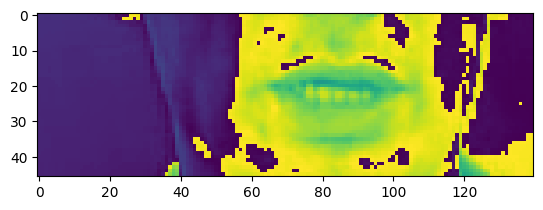

In [ ]:
plt.imshow(frames[28])

In [ ]:
alignments

<tf.Tensor: shape=(21,), dtype=int64, numpy=
array([ 2,  9, 14, 39,  2, 12, 21,  5, 39,  1, 20, 39, 12, 39, 19,  9, 24,
       39, 14, 15, 23])>

In [ ]:
tf.strings.reduce_join([bytes.decode(x) for x in num_to_char(alignments.numpy()).numpy()]).numpy().decode('utf-8')

'bin blue at l six now'

In [ ]:
def mappable_function(path:str) ->List[str]:
    # Call the load_data function using TensorFlow's py_function, which can be used to wrap Python functions
    # and make them usable inside a TensorFlow graph.
    # This allows us to load and preprocess data in parallel with TensorFlow's data pipeline.
    result = tf.py_function(load_data, [path], (tf.float32, tf.int64))
    # Return the loaded and preprocessed data
    return result

# Create data pipeline

In [ ]:
#load all video files,converts each video and label to tensors
# Get list of file paths for all videos
data = tf.data.Dataset.list_files('./data/s1/*.mpg')
# Shuffle the order of the videos
data = data.shuffle(500, reshuffle_each_iteration=False)
# Map the load_data function to each file path and get frames and alignments
data = data.map(mappable_function)
# Padded batch of 2 videos, with frames padded to 75 frames and alignments padded to 40 characters
data = data.padded_batch(2, padded_shapes=([75,None,None,None],[40]))
# Prefetch to optimize for performance
data = data.prefetch(tf.data.AUTOTUNE)
# Split the data into train and test sets
train = data.take(450)
test = data.skip(450)

In [ ]:
len(test)


50

In [ ]:
frames, alignments = data.as_numpy_iterator().next()


In [ ]:
len(frames)


2

In [ ]:
sample = data.as_numpy_iterator()


In [ ]:
val = sample.next(); val[0]


array([[[[[1.3985687 ],
          [1.3985687 ],
          [1.4721776 ],
          ...,
          [0.29443553],
          [0.33123997],
          [0.33123997]],

         [[1.2881554 ],
          [1.3985687 ],
          [1.5457866 ],
          ...,
          [0.29443553],
          [0.33123997],
          [0.33123997]],

         [[1.4353732 ],
          [1.4353732 ],
          [1.4353732 ],
          ...,
          [0.33123997],
          [0.2576311 ],
          [0.2576311 ]],

         ...,

         [[1.0673288 ],
          [1.0305244 ],
          [1.0305244 ],
          ...,
          [0.07360888],
          [0.03680444],
          [0.03680444]],

         [[1.0305244 ],
          [1.0305244 ],
          [1.0305244 ],
          ...,
          [0.07360888],
          [0.03680444],
          [0.03680444]],

         [[1.0305244 ],
          [1.0305244 ],
          [1.0305244 ],
          ...,
          [0.07360888],
          [0.03680444],
          [0.03680444]]],


        [[[1.4721

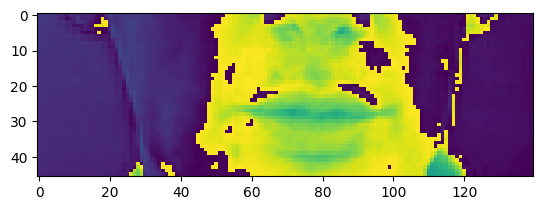

In [ ]:
plt.imshow(val[0][0][35])


In [ ]:
tf.strings.reduce_join([num_to_char(word) for word in val[1][0]])


<tf.Tensor: shape=(), dtype=string, numpy=b'set white at o seven again'>

# Design the deep neural network

In [ ]:
import os
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, Activation, MaxPool3D, TimeDistributed, GlobalAveragePooling2D
from tensorflow.keras.layers import Bidirectional, LSTM, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping


In [ ]:
data.as_numpy_iterator().next()[0][0].shape


(75, 46, 140, 1)

In [ ]:
#  Model Architecture 
def build_model(char_to_num):
    model = Sequential()
    model.add(Conv3D(128, 3, input_shape=(75, 46, 140, 1), padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPool3D((1, 2, 2)))

    model.add(Conv3D(256, 3, padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPool3D((1, 2, 2)))

    model.add(Conv3D(75, 3, padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPool3D((1, 2, 2)))

    model.add(TimeDistributed(GlobalAveragePooling2D())) #a way to summarize the information in a 2D feature map
    model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
    model.add(Dropout(0.5))# Randomly drops 50% of the output to prevent overfitting.
    model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
    model.add(Dropout(0.5))

    model.add(Dense(char_to_num.vocabulary_size() + 1, kernel_initializer='he_normal', activation='softmax'))
    return model

In [ ]:
model = build_model(char_to_num)
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d (Conv3D)                 │ (None, 75, 46, 140,    │         3,584 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 75, 46, 140,    │             0 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d (MaxPooling3D)    │ (None, 75, 23, 70,     │             0 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_1 (Conv3D)               │ (None, 75, 23, 70,     │       884,992 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 75, 23, 70,     │             0 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_1 (MaxPooling3D)  │ (None, 75, 11, 35,     │             0 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_2 (Conv3D)               │ (None, 75, 11, 35, 75) │       518,475 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 75, 11, 35, 75) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_2 (MaxPooling3D)  │ (None, 75, 5, 17, 75)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 75, 75)         │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 75, 256)        │       208,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 75, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 75, 256)        │       394,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 75, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 75, 41)         │        10,537 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,020,724 (7.71 MB)

 Trainable params: 2,020,724 (7.71 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
tf.strings.reduce_join([num_to_char(x) for x in tf.argmax(yhat[0],axis=1)])


<tf.Tensor: shape=(), dtype=string, numpy=b'eeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeekkkkkkk5111'>

In [ ]:
tf.strings.reduce_join([num_to_char(tf.argmax(x)) for x in yhat[0]])


<tf.Tensor: shape=(), dtype=string, numpy=b'eeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeekkkkkkk5111'>

# Setup training options and train

In [ ]:
#This function defines a learning rate scheduler that decays the learning rate exponentially
#after the 30th epoch. The scheduler function takes the epoch number and the current learning rate
#as inputs and returns the new learning rate to be used for the next epoch.

def scheduler(epoch, lr):
    if epoch < 30:
        return float(lr)
    else: # slowly reduce it (decay it) each epoch
        return float(lr * tf.math.exp(-0.1).numpy())  # Ensure output is pure float
# This helps the model learn faster in the beginning, then settle down and fine-tune gently

In [ ]:
#This function computes the Connectionist Temporal Classification (CTC) loss between the predicted labels and true labels.
#It takes two inputs, y_true and y_pred, which are the true and predicted labels respectively.

def CTCLoss(y_true, y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    # Create tensors of shape (batch_size, 1) with the input and label lengths
    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    # Compute the CTC loss using the backend function ctc_batch_cost
    loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

In [ ]:

# === Callbacks Setup ===
checkpoint_callback = ModelCheckpoint(
    filepath='/content/drive/MyDrive/Colab Notebook/models/checkpoint.weights.h5',
    monitor='loss',
    save_weights_only=True,
    save_best_only=False,
    save_freq='epoch'
)

In [ ]:
early_stop_callback = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

In [ ]:
schedule_callback = LearningRateScheduler(scheduler)
example_callback = ProduceExample(test)

In [ ]:

# === Training Resume Function ===
def resume_training(train, test, build_model, checkpoint_path, start_epoch, end_epoch, initial_lr, callbacks):
    model = build_model()
    model.compile(optimizer=Adam(learning_rate=initial_lr), loss=CTCLoss)

    if os.path.exists(checkpoint_path):
        model.load_weights(checkpoint_path)
        print(f" Loaded weights from {checkpoint_path}")
    else:
        print(f" No checkpoint found at {checkpoint_path}, training from scratch.")

    history = model.fit(
        train,
        validation_data=test,
        initial_epoch=start_epoch,
        epochs=end_epoch,
        callbacks=callbacks
    )

    return model, history

In [ ]:
# === Execute One Chunk of Training (example: epochs 25–50) ===
model, history = resume_training(
    train=train,
    test=test,
    build_model=lambda: build_model(char_to_num),
    checkpoint_path='/content/drive/MyDrive/Colab Notebook/models/checkpoint.weights.h5',
    start_epoch=130,
    end_epoch=140,
    initial_lr=1e-4,
    callbacks=[
        checkpoint_callback,
        schedule_callback,
        early_stop_callback,
        example_callback
    ]
)

✅ Loaded weights from /content/drive/MyDrive/Colab Notebook/models/checkpoint.weights.h5
Epoch 131/140
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Original: place red with x eight please
Prediction: plac gren with x sigh please
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: bin blue in e eight now
Prediction: bin blue in g eight now
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 ━━━━━━━━━━━━━━━━━━━━ 657s 1s/step - loss: 14.3696 - val_loss: 11.8573 - learning_rate: 9.0484e-05
Epoch 132/140
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step
Original: bin green by o zero please
Prediction: bin gren by y zer please
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: place red with k zero please
Prediction: place gred with z zero please
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

In [ ]:
# === Final Save ===
model.save('/content/drive/MyDrive/Colab Notebook/models/final_model.keras')
print("Final model saved.")

✅ Final model saved.


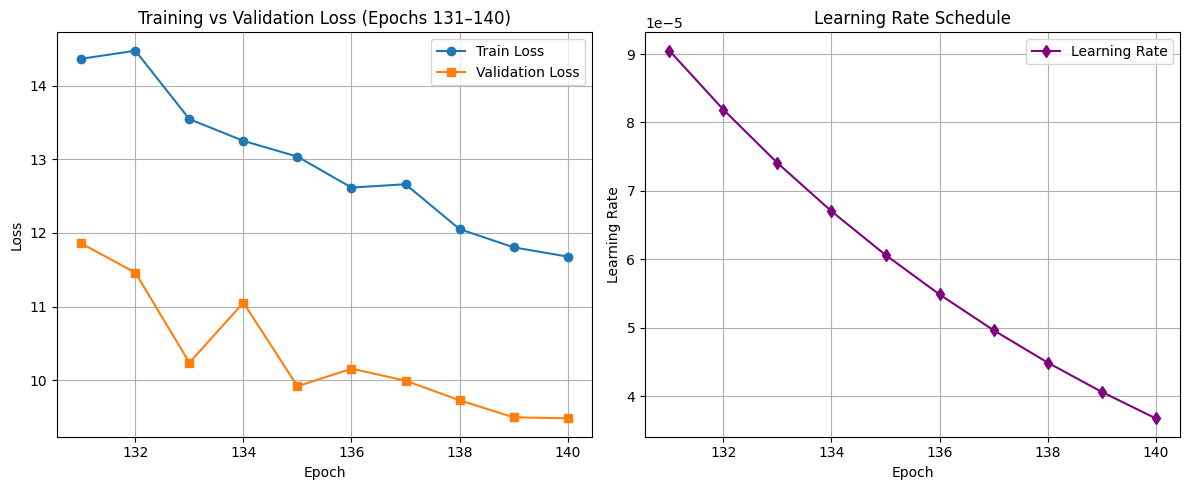

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Epochs
epochs = list(range(131, 141))

# Training loss and validation loss from logs
train_loss = [
    14.3696, 14.4790, 13.5481, 13.2529, 13.0383,
    12.6178, 12.6628, 12.0527, 11.8048, 11.6790
]

val_loss = [
    11.8573, 11.4594, 10.2361, 11.0518, 9.9155,
    10.1547, 9.9912, 9.7252, 9.4927, 9.4789
]

# Learning rate per epoch
learning_rate = [
    9.0484e-05, 8.1873e-05, 7.4082e-05, 6.7032e-05, 6.0653e-05,
    5.4881e-05, 4.9659e-05, 4.4933e-05, 4.0657e-05, 3.6788e-05
]

# Plotting Loss curves
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, marker='o', label='Train Loss')
plt.plot(epochs, val_loss, marker='s', label='Validation Loss')
plt.title('Training vs Validation Loss (Epochs 131–140)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

# Plotting Learning Rate
plt.subplot(1, 2, 2)
plt.plot(epochs, learning_rate, marker='d', color='purple', label='Learning Rate')
plt.title('Learning Rate Schedule')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


# Make a prediction

In [ ]:
# URL to the zip file containing checkpoints
url ='https://drive.google.com/drive/u/0/folders/1xvq472Wgx9OHV2dEicYV3BzfRBdhbCRz'
# Name of the output zip file
output = 'checkpoints.weights.h5'
# Download the zip file from Google Drive
gdown.download(url, output, quiet=False)


Downloading...
From: https://drive.google.com/drive/u/0/folders/1xvq472Wgx9OHV2dEicYV3BzfRBdhbCRz
To: /content/checkpoints.weights.h5
1.08MB [00:00, 10.3MB/s]


'checkpoints.weights.h5'

In [ ]:
#model.load_weights('models/checkpoint')


In [ ]:
from tensorflow.keras.optimizers import Adam
optimizer = Adam(learning_rate=0.001)

# Compile the model with the same optimizer
model.compile(loss=CTCLoss, optimizer=optimizer)

# Load the saved weights
model.load_weights('/content/drive/MyDrive/Colab Notebook/models/checkpoint.weights.h5')


In [ ]:
test_data = test.as_numpy_iterator()
sample = test_data.next()
yhat = model.predict(sample[0])


In [ ]:
print('~'*100, 'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in sample[1]]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ REAL TEXT


[<tf.Tensor: shape=(), dtype=string, numpy=b'set green in o seven soon'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'place white by q five soon'>]

In [ ]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75,75], greedy=True)[0][0].numpy()


In [ ]:
print('~'*100, 'PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ PREDICTIONS


[<tf.Tensor: shape=(), dtype=string, numpy=b'set green it v sinee soon'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'place white by m fiven soon'>]

# Test on a video

In [ ]:
sample = load_data(tf.convert_to_tensor('./data/s1/bbie8n.mpg'))


In [ ]:
print('~'*100, 'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in [sample[1]]]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ REAL TEXT


[<tf.Tensor: shape=(), dtype=string, numpy=b'bin blue in e eight now'>]

In [ ]:
yhat = model.predict(tf.expand_dims(sample[0], axis=0))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


In [ ]:
decoded, _ = tf.keras.backend.ctc_decode(yhat, input_length=[75], greedy=False, beam_width=20)
decoded = decoded[0].numpy()

In [ ]:
print('~'*100, 'PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ PREDICTIONS


[<tf.Tensor: shape=(), dtype=string, numpy=b'bin blue it g eight now'>]

In [3]:
!pip install levenshtein

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 161.7/161.7 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 68.8 MB/s eta 0:00:00


In [4]:
from Levenshtein import distance as levenshtein_distance

In [5]:
ground_truth= "bin blue in e eight now"

In [6]:
prediction= "bin blue it g eight now"

In [7]:
def levenshtein_distance(a: str, b: str) -> int:
    dp = [[0] * (len(b) + 1) for _ in range(len(a) + 1)]
    for i in range(len(a) + 1): dp[i][0] = i
    for j in range(len(b) + 1): dp[0][j] = j
    for i in range(1, len(a) + 1):
        for j in range(1, len(b) + 1):
            cost = 0 if a[i - 1] == b[j - 1] else 1
            dp[i][j] = min(
                dp[i - 1][j] + 1,
                dp[i][j - 1] + 1,
                dp[i - 1][j - 1] + cost
            )
    return dp[-1][-1]

In [8]:
# Compute metrics
lev_dist = levenshtein_distance(ground_truth, prediction)
normalized = lev_dist / max(len(ground_truth), 1)
accuracy = 1 - normalized

In [9]:
# Print report
print("~" * 100)
print("GROUND TRUTH: ", ground_truth)
print("PREDICTION:   ", prediction)
print("LEVENSHTEIN DISTANCE: ", lev_dist)
print("NORMALIZED DISTANCE: ", round(normalized, 3))
print("ESTIMATED ACCURACY:  ", round(accuracy * 100, 2), "%")

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
GROUND TRUTH:  bin blue in e eight now
PREDICTION:    bin blue it g eight now
LEVENSHTEIN DISTANCE:  2
NORMALIZED DISTANCE:  0.087
ESTIMATED ACCURACY:   91.3 %


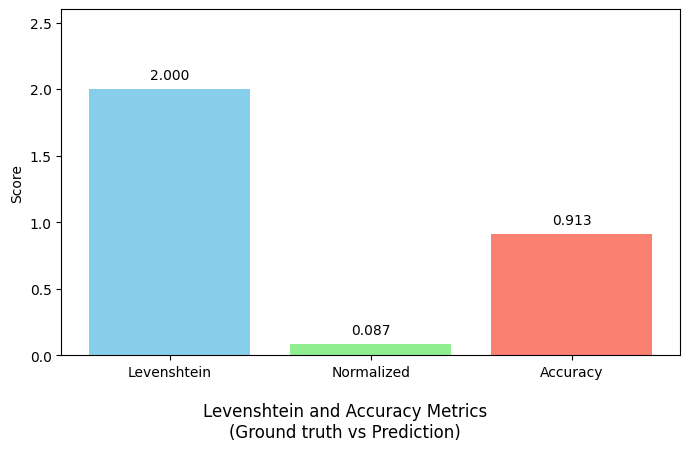

In [13]:
# Plotting
plt.figure(figsize=(7, 4))
metrics = ["Levenshtein", "Normalized", "Accuracy"]
scores = [lev_dist, normalized, accuracy]
colors = ["skyblue", "lightgreen", "salmon"]

bars = plt.bar(metrics, scores, color=colors)

# Annotate bars
for bar, score in zip(bars, scores):
    plt.text(bar.get_x() + bar.get_width() / 2,
             bar.get_height() + 0.05,
             f"{score:.3f}",
             ha='center', va='bottom', fontsize=10)

# Adjust y-axis to fit high value
plt.ylim(0, max(scores) + 0.6)

# Main label moved below graph
plt.figtext(0.5, -0.1, "Levenshtein and Accuracy Metrics\n(Ground truth vs Prediction)",
            wrap=True, horizontalalignment='center', fontsize=12)

plt.ylabel("Score")
plt.tight_layout()
plt.show()

In [3]:
!pip install jiwer



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
from jiwer import wer

predictions = []      
ground_truths = [] 

# Calculate WER for each prediction and average
wers = [wer(gt, pred) for gt, pred in zip(ground_truths, predictions)]
average_wer = sum(wers) / len(wers)

print("Word Error Rates:", wers)
print("Average WER:", average_wer)


Word Error Rates: [0.3333333333333333]
Average WER: 0.3333333333333333


   Sample #                Ground Truth                  Prediction       WER
0         1     bin blue in e eight now     bin blue it g eight now  0.333333
1         2  lay blue at e eight please  lay blue at d eight please  0.166667


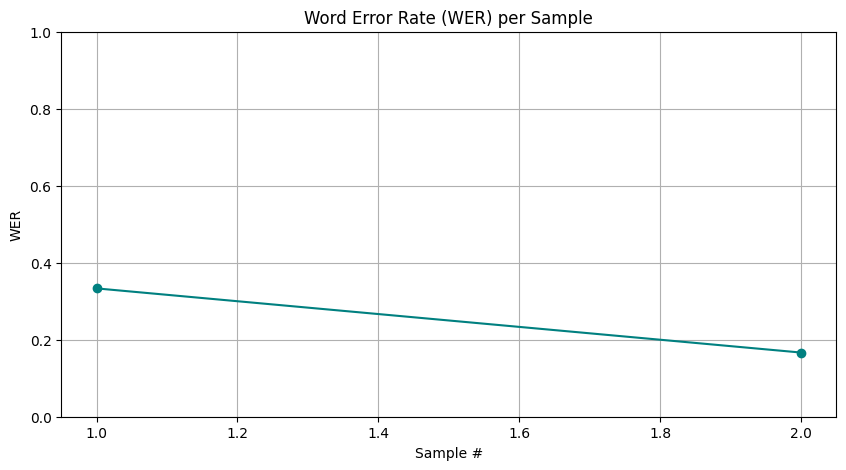

In [7]:
from jiwer import wer
import pandas as pd
import matplotlib.pyplot as plt

# Replace these with your actual prediction and ground truth lists
predictions = [
    "bin blue it g eight now",
    "lay blue at d eight please"
]
ground_truths = [
    "bin blue in e eight now",
    "lay blue at e eight please"
]

# Compute WER for each pair
wers = [wer(gt, pred) for gt, pred in zip(ground_truths, predictions)]

# Create a DataFrame for analysis and plotting
df_wer = pd.DataFrame({
    "Sample #": range(1, len(predictions)+1),
    "Ground Truth": ground_truths,
    "Prediction": predictions,
    "WER": wers
})

# Display the DataFrame
print(df_wer)

# Plot WER per sample
plt.figure(figsize=(10, 5))
plt.plot(df_wer["Sample #"], df_wer["WER"], marker='o', linestyle='-', color='teal')
plt.title("Word Error Rate (WER) per Sample")
plt.xlabel("Sample #")
plt.ylabel("WER")
plt.ylim(0, 1)
plt.grid(True)
plt.show()
